# INF8775 – Analyse et conception d’algorithmes
# TP2 – Hiver 2024

QURESHI, Junaid, 2149457

ARSENAULT, Charles, 214242

Note finale :

 <u>**Date limite de remise :**</u>  27 mars 23h59 (Groupe B1), 19 mars 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition (en gris).

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time
import random

In [2]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.    
    """
    # Create a figure and axis
    _, ax = plt.subplots()
    
    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')
    
    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)
    
    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)
    
    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)    
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [34]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [35]:
def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        _, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Partie 1 : Algorithme glouton

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 154


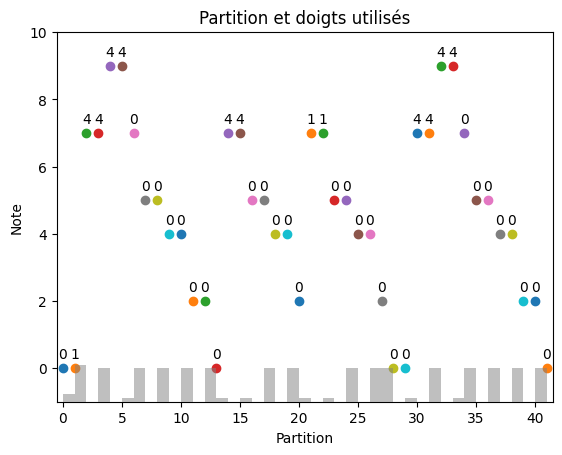

In [36]:
def glouton(partition):
    solution = [0,1]
    for i in range(2,len(partition)):
        min = 0
        cost = costs[partition[i - 1], solution[i - 1], partition[i], 0]
        for j in range(1,D):
            newCost = costs[partition[i - 1], solution[i - 1], partition[i], j]
            if cost > newCost:
                cost = newCost
                min = j
        solution.append(min)
    return solution

        

solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

La boucle externe itère à travers (n - 2) éléments, où n est égale à la longeur de la parition. Donc la complexité temporelle asymptotique est de O(M). Excluant la boucle interne, les opération à l'intérieur de cette première boucle sont élémentaires, donc ils sont O(1). 

La boucle interne itère à travers D éléments, où D est égale au nombre de doigts disponibles, donc sa complexité asymptotique est de O(D). Encore une fois, les opérations se retrouvant dans celle-ci sont O(1).

La complexité asymptotique finale est de O(n * D). 

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [40]:
dataset = get_dataset(2149457, [10000,20000,40000,80000,160000,200000,240000,280000,320000,360000,400000,500000])
measure_greedy = measure_procedure(glouton, dataset)
display_measures_table(measure_greedy)

Taille       Temps moyen (s)5 of size 500000...          
10000        0.035756397247314456
20000        0.09334478378295899
40000        0.1467386245727539
80000        0.3282748222351074
160000       0.6304711818695068
200000       0.7919257640838623
240000       0.9439230918884277
280000       1.0766228199005128
320000       1.2962407112121581
360000       1.4728657722473144
400000       1.5828185558319092
500000       1.935062313079834


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

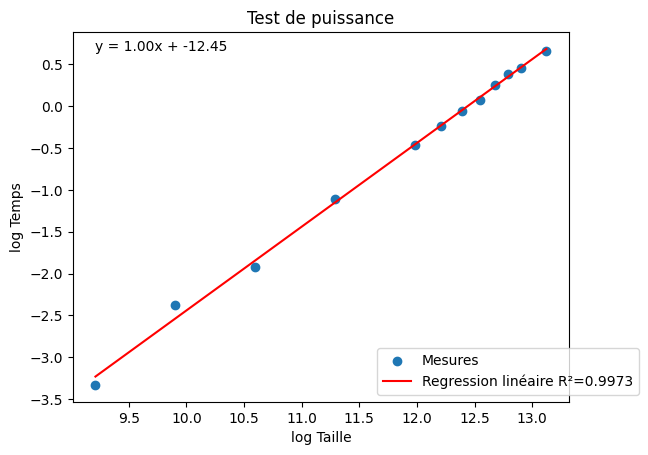

In [41]:
import math

def values_test_puissance(measures):
    return {
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }


def values_test_rapport(measures, f):
    return {
        size : measure/f(size)
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return 5*x

display_test_puissance(values_test_puissance(measure_greedy), title="Test de puissance")

Comme le montrent le graphique et l'équation créés à partir du test de puissance, la puissance de notre algorithme est très proche de un. C'est le cas, car nous considérons que le nombre de doigts, D, est constant. Compte tenu de ce fait, cette conclusion est toujours cohérente avec notre hypothèse initiale d'un algorithme qui évolue linéairement si nous ne faisons varier que n, la longueur de la partition (O(5N)). 

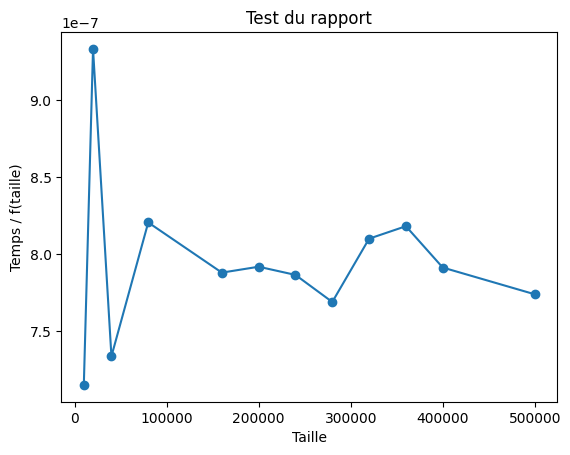

In [42]:
display_test_rapport(values_test_rapport(measure_greedy, f))

En utilisant la valeur de puissance déterminée précédemment dans notre fonction de test de rapport, nous confirmons l'exactitude de notre modèle. Notre algorithme converge vers une valeur positive non nulle de 7.8 e-7.

## Partie 2 : Algorithme de programmation dynamique

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

Coût Programmation Dynamique : 31


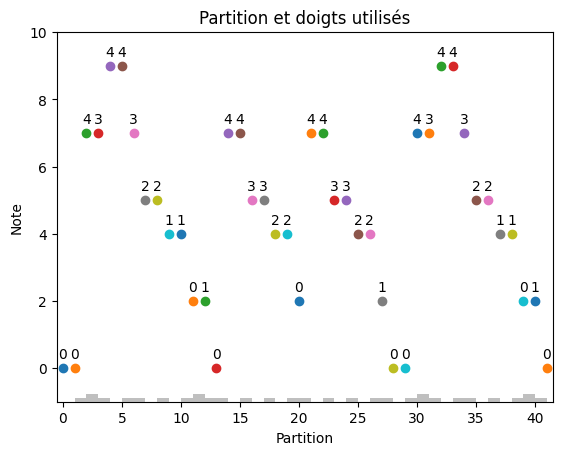

In [43]:
def progDyn(partition):
    n = len(partition)
    
    solution = [0 for i in range(n)]
    dp = [[0 for _ in range(D)] for _ in range(n)]

    for k in range(n-2, -1, -1):
        for d in range(D):
            dp[k][d] = min(costs[partition[k], d, partition[k+1], d_prime] + dp[k+1][d_prime] for d_prime in range(D))


    solution[0] = min(range(D), key=lambda d: dp[0][d])

    for k in range(1, n):
        solution[k] = min(range(D), key=lambda d_prime: costs[partition[k-1], solution[k-1], partition[k], d_prime] + dp[k][d_prime])
    return solution

solutionDyn = progDyn(partition)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

Lors de l'initialisation du tableau de solutions, l'algorithme crée un tableau de longueur n, la longueur de la partition, et le remplit avec des 0, ce qui est une opération O(n) en termes de complexité temporelle.  

Le deuxième tableau "dp" a une complexité encore plus élevée car il crée une matrice de n x D éléments, où D est le nombre de doigts utilisés. Comme pour le premier tableau, la complexité asymptotique correspond au nombre d'itérations, soit O(n*D).

La première boucle for itère à travers les indices de k en commençant de n-2 et descendant jusqu'à 0, où n est la longeur de la partition. Pour chaque k, elle itère également à travers les valeurs de d. Dans chaque itération de cette boucle, il y a une expression qui utilise des opérations élémentaires (tel que min() et l'assignation) pour chaque doigts, ce qui a une complexité de O(D). Donc, la complexité de cette boucle est O(n * D^2).

La deuxième boucle itère à travers les indices de k de 1 à n-1. À chaque itération, elle effectue une opération de recherche de minimum parmi D éléments, ce qui a une complexité de O(D). Donc, la complexité de cette boucle est O(n * D).

En combinant ces étapes, la complexité temporelle totale de l'algorithme est dominée par la première boucle for, soit O(n * D^2).

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [61]:
dataset = get_dataset(2149457, [40000,50000,60000,70000,80000,90000,100000])
measure_dyn = measure_procedure(progDyn, dataset)
display_measures_table(measure_dyn)

Taille       Temps moyen (s)5 of size 100000...          
40000        1.5775002002716065
50000        1.8778733730316162
60000        2.2249783515930175
70000        2.6283760547637938
80000        2.965059185028076
90000        3.3573941230773925
100000       3.698328638076782


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

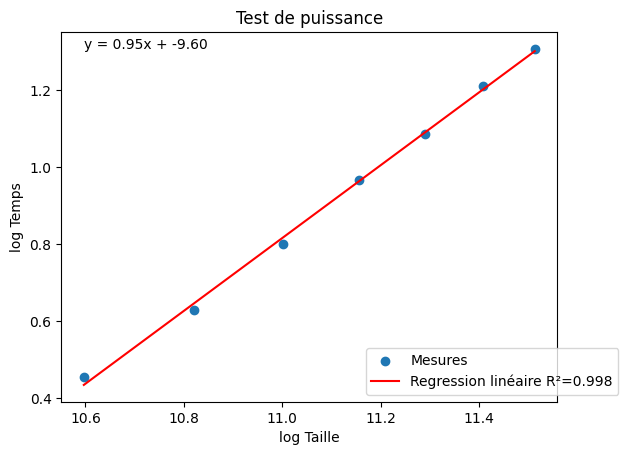

In [62]:
def values_test_puissance(measures):
    return {
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }
def values_test_rapport(measures, f):
    return {
        size : measure/f(size)
        for size, measure in measures.items()
    }
def values_test_constantes(measures, f):
    return { 
        f(size): measure for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return 25*x

display_test_puissance(values_test_puissance(measure_dyn), title="Test de puissance")


Tout comme le premier algorithme, la conclusion de ce test nous donne un degré proche de un. C'est le résultat attendu car la variable qui fait de cet algorithme un algorithme plus lent est D, cependant dans nos tests nous la gardons constante. Notre hypothèse peut encore être quelque peu confirmée, car le degré de n, la longueur de la partition, correspond à la puissance trouvée. 

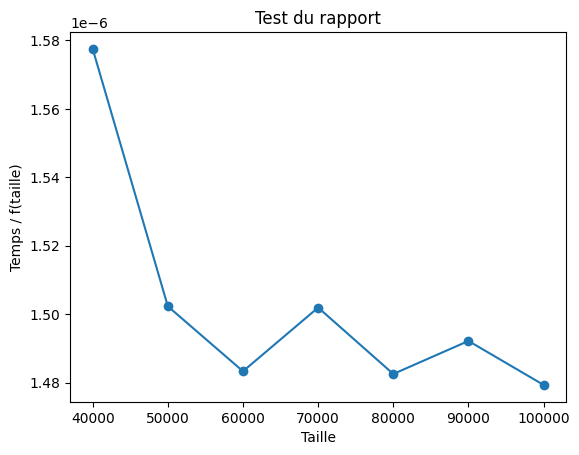

In [63]:
display_test_rapport(values_test_rapport(measure_dyn, f))

*Insérer votre réponse ici*

## Partie 3 : Algorithme de recherche locale

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

Coût Recherche Locale : 1532


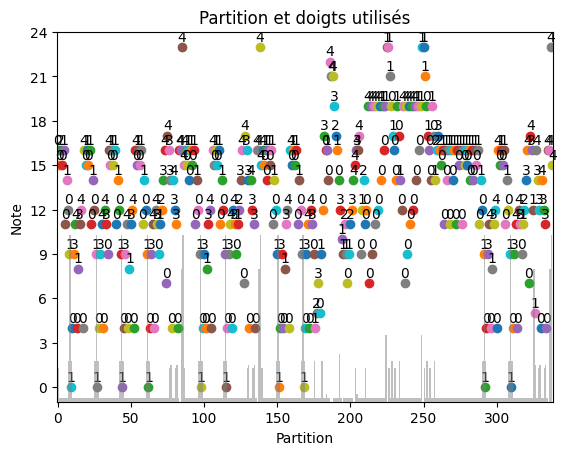

In [11]:
def local_search(partition):
    solution = glouton(partition)
    improved = True
    while improved:
        improved = False
        for i in range(1, len(partition) - 1):
            for j in range(D):
                new_solution = solution.copy()
                new_solution[i] = j
                if getTotalCost(costs, partition, new_solution) < getTotalCost(costs, partition, solution):
                    solution = new_solution
                    improved = True
    return solution

solutionLocalSearch = local_search(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocalSearch))
visualize_solution(costs, partition, solutionLocalSearch)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

La fonction de recherche local utilise la fonction glouton pour générer une première solution. L'appel de la fonction glouton est d'une complexité temporelle de O(n*D) ou n est la longueur de la partition et D est le nombre de doigts. 

Dans la fonction de recherche local, la boucle while continue de s'éxecuter tant qu'il y a une amélioration de la solution, cela peut donc produire beaucoup de variance et créer un meilleur temps et un pire temps très distinct. À l'intérieur de cette boucle, une boucle for itère sur les n éléments de la partition et les D doigts. À chacune de ses itérations on vérifie le coût précédent et le coût de la nouvelle solution ce qui correspond à des opérations de complexité n, on fait également une éxécution de la fonction copy() de python qui est de complexité n. Ces fonctions sont donc éxécutés à chaque itération et l'on se retrouve à les éxécuter en moyenne n*D*(3n) fois, soit une complexité en cas moyen de l'algorithme de recherche locale de O(n^2*D). 

Dans le pire cas, la meilleur solution est trouvé qu'après avoir itéré à travers tout, soit encore une fois O(n^2*D). Cependant en meilleur cas, il est possible de ne pas trouvé d'amélioration très rapidement et donc la solution de l'algorithme glouton est un minimum et l'algorithme possède donc seulement la complexité du premier appel à la fonction glouton, soit O(nD).

### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [23]:
dataset = get_dataset(2149457, [100, 200, 400, 800, 1000, 1100, 1200, 1300, 1400, 1500,2000,2500,3000])
measure_localSearch = measure_procedure(local_search, dataset)
display_measures_table(measure_localSearch)

Taille       Temps moyen (s)mple 5 of size 300...          
10           0.0024747848510742188
20           0.012504673004150391
40           0.040766429901123044
80           0.09433674812316895
100          0.14153070449829103
110          0.16437478065490724
120          0.21045570373535155
130          0.2712209224700928
140          0.2846644878387451
150          0.3401341438293457
200          0.546146297454834
250          0.807752275466919
300          1.2066923141479493


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

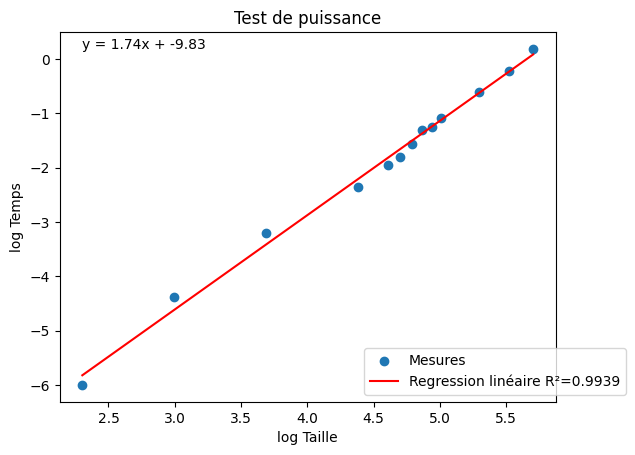

In [24]:
def values_test_puissance(measures):
    return {
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }
display_test_puissance(values_test_puissance(measure_localSearch), title="Test de puissance")

Nous avons effectuer le test de puissance afin de vérifier le degré de l'algorithme. En vérifiant les temps, on s'apperçoit déjà que la fonction ne croit pas en temps linéairement selon la taille des exemplaires. Le test nous révèle une pente d'environ 2 avec un très haut taux de regression linéaire ce qui s'aligne avec notre hypothèse d'un algorithme de degré 2. La régression linéaire du test de puissance en logarithme est determiner ainsi log(temps) = m*log(taille) + b, la pente m donne donc => y= cst * x^m, soit la croissance polynomiale de degré m, dans notre cas environ 2 et qui confirme notre hypothèse initiale.

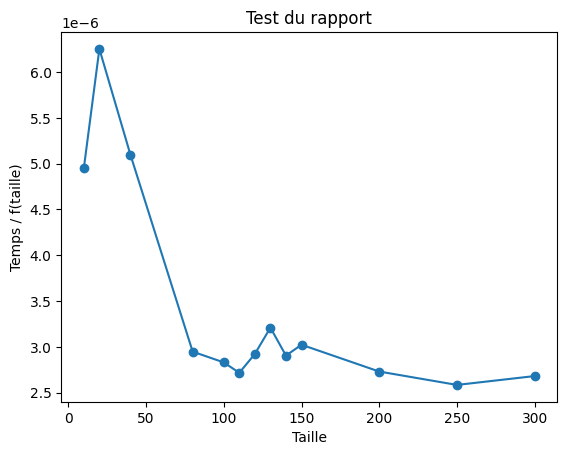

In [25]:
def values_test_rapport(measures, f):
    return {
        size : measure/f(size)
        for size, measure in measures.items()
    }

def f(x):
    return 5*(x**2)
display_test_rapport(values_test_rapport(measure_localSearch, f))

En définissant une fonction f de degré 2, le test du rapport nous permet de vérifier que le taux de croissance de l'algorithme s'apparente à celui de la fonction lorsqu'il converge. À l'aide du graphique, on s'apperçoit que le test converge vers une constante non-nulle positive et que l'algorithme possède un taux de croissance qui s'apparente à la fonction f(x) = 5*x^2, et l'on peut donc préciser notre mesure avec le facteur vers lequel le test du rapport converge soit environ 2.3. 

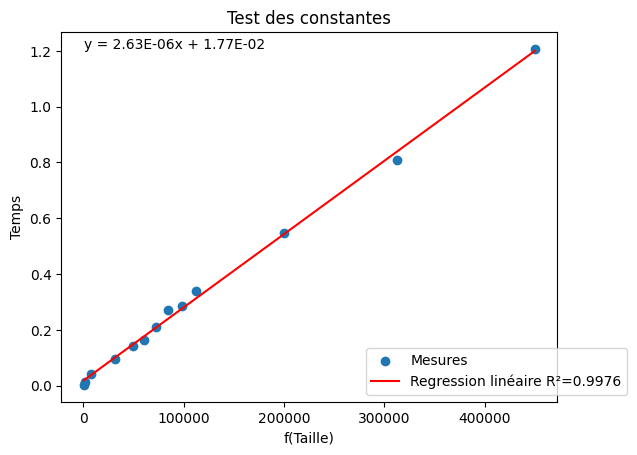

In [26]:
display_test_constantes(values_test_constantes(measure_localSearch, f))

Le test des constantes nous permet de confirmer que la complexité asymptotique de l'algorithme de recherche locale s'apparente bel et bien à la fonction f(x)=5*x^2 que nous avons poser avec un taux de regression de 0.9942. On s'apperçoit également que la pente du test de 2.29 confirme la convergence du test du rapport vers le facteur b d'environ 2.3.

# Conclusion et synthèse

Résumez succintement vos résultats et indiquez sous quelles conditions vous utiliseriez chacun des algorithmes.

Pour conclure, nous avons pu approcher le problème avec 3 algorithmes différents, chacun qui comporte leurs avantages respectifs. 

D'abord, nous avons construit un algorithme glouton d'une complexité temporelle suivant l'ordre de O(n*D), n étant la taille de la partition et D étant le nombre de doigts pour jouer la partition. Cette approche s'avère à être la plus rapide des trois approches dans le cas de grands exemplaires, cependant, la solution qu'offre cette approche n'est définitivement pas la plus optimale. Dans le cas de l'exemplaire fourni twinkle_twinkle.txt, la solution de cette approche nous donne un coût total de 154. C'est donc un approche qui est préférable lorsqu'on ne veut pas avoir la solution la plus optimale, mais lorsqu'on veut obtenir une solution fonctionnel le plus rapidement possible c'est une approche qui convient bien à ces besoins. 

La deuxième approche que nous avons implémentés est une solution qui utilise la programmation dynamique. L'algorithme que nous avons construit possède une complexité temporelle de TODO. Cette complexité croit beaucoup plus que celle de l'approche glouton, par contre, elle offre une bien meilleure solution soit d'un coût total de 31 pour la même partition et le même nombre de doigts. L'algorithme de programmation dynamique possède également un besoin en mémoire plus grand que les autres algorithme puisqu'il génère un tableau avec plusieurs solutions pour trouver celle qui est optimale. Dans le cas ou le temps et l'espace mémoire n'est pas un problème, cette approche donne la solution la plus optimale à une partition. 

La troisième approche est celle de l'algorithme de recherche locale. Cette approche utilise l'algorithme glouton pour générer une première solution et ensuite cherche à l'améliorer. L'algorithme que nous avons conçu possède une complexité de O(n^2*D) en cas moyen et en pire cas, et une complexité identique à celle glouton en meilleur cas. Cette approche ne permet pas de trouver la solution la plus optimale comme dans celle de programmation dynamique, mais offre une meilleur solution que celle glouton avec un coût total de 55. C'est donc une solution qui borne supérieurement l'approche glouton, mais qui offre une meilleur solution. Elle peut donc être utile si on veut une solution qui est relativement bonne, sans compromettre le temps et l'espace mémoire de l'approche dynamique. En bref, les trois approches répondent à des besoins différents et peuvent être optimale selon le contexte requis.